In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import json
import numpy as np
import os

2025-05-20 23:55:59.192586: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazz/.x-cmd.root/local/data/pkg/sphere/X/l/j/h/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2025-05-20 23:55:59.192629: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load JSON data
with open('labels.json') as f:
    data = json.load(f)

# Extract all unique classes from annotations
all_classes = ['Dirt', 'Asphalt', 'Gravel', 'Mud', 'Snow-covered', 'Brick']
class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}

# Prepare dataset - only include files that exist
image_paths = []
labels = []

for item in data:
    img_path = item['image']
    full_path = os.path.join('image', img_path)
    
    if os.path.exists(full_path):
        image_paths.append(img_path)
        # Create multi-hot encoded label vector
        label_vec = [0] * len(all_classes)
        for annotation in item['annotations']:
            label_vec[class_to_idx[annotation.strip()]] = 1
        labels.append(label_vec)

print(f"Found {len(image_paths)} valid images out of {len(data)} in JSON")

# Convert to numpy arrays
labels = np.array(labels, dtype=np.float32)

Found 172 valid images out of 181 in JSON


In [3]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 15
VAL_SPLIT = 0.2

In [4]:
# Create TensorFlow dataset
def load_and_preprocess_image(image_path, label):
    full_path = tf.strings.join(['image/', image_path])
    img = tf.io.read_file(full_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_and_preprocess_image)

# Shuffle and split dataset
dataset_size = len(image_paths)
train_size = int((1 - VAL_SPLIT) * dataset_size)

dataset = dataset.shuffle(buffer_size=dataset_size)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

2025-05-20 23:56:20.507547: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazz/.x-cmd.root/local/data/pkg/sphere/X/l/j/h/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2025-05-20 23:56:20.507598: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-20 23:56:20.507630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jazz-ThinkPad-S1-Yoga): /proc/driver/nvidia/version does not exist
2025-05-20 23:56:20.529905: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in perfo

In [5]:
# Build CNN model for single-label classification
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(len(all_classes), activation='softmax')  # Changed to softmax
])

In [6]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/15


2025-05-20 23:56:30.360255: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 50466816 exceeds 10% of free system memory.
2025-05-20 23:56:30.810613: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 24332288 exceeds 10% of free system memory.
2025-05-20 23:56:31.505759: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 24920064 exceeds 10% of free system memory.
2025-05-20 23:56:31.633833: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 24332288 exceeds 10% of free system memory.
2025-05-20 23:56:31.677784: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 27373824 exceeds 10% of free system memory.


18/18 [==============================] - 13s 718ms/step - loss: 0.4915 - accuracy: 0.3139 - val_loss: 0.4056 - val_accuracy: 0.5143
Epoch 2/15
18/18 [==============================] - 13s 709ms/step - loss: 0.3745 - accuracy: 0.5474 - val_loss: 0.3030 - val_accuracy: 0.6000
Epoch 3/15
18/18 [==============================] - 12s 691ms/step - loss: 0.3059 - accuracy: 0.6058 - val_loss: 0.2032 - val_accuracy: 0.7429
Epoch 4/15
18/18 [==============================] - 12s 662ms/step - loss: 0.2214 - accuracy: 0.7372 - val_loss: 0.1683 - val_accuracy: 0.8000
Epoch 5/15
18/18 [==============================] - 12s 690ms/step - loss: 0.1832 - accuracy: 0.7591 - val_loss: 0.1245 - val_accuracy: 0.8571
Epoch 6/15
18/18 [==============================] - 13s 695ms/step - loss: 0.1718 - accuracy: 0.7956 - val_loss: 0.1615 - val_accuracy: 0.7429
Epoch 7/15
18/18 [==============================] - 13s 713ms/step - loss: 0.1579 - accuracy: 0.7810 - val_loss: 0.1155 - val_accuracy: 0.8857
Epoch 8/15

In [8]:
# Evaluate
model.evaluate(val_dataset)

5/5 [==============================] - 1s 108ms/step - loss: 0.0954 - accuracy: 0.9143


[0.09540049731731415, 0.9142857193946838]

In [9]:
model.save('road_surface_classifier.h5')

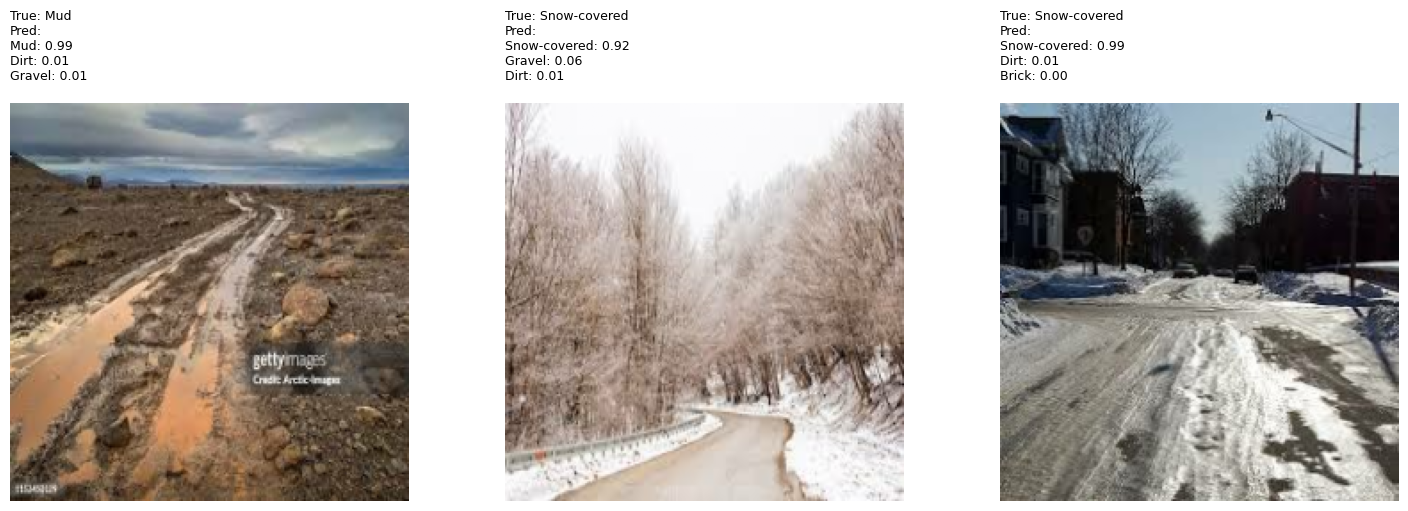

In [12]:
# Cell to showcase detection examples using saved model
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('road_surface_classifier.h5')

# Select 3 sample images from validation set
sample_images = []
for img, label in val_dataset.take(3):
    sample_images.append((img.numpy(), label.numpy()))
    
plt.figure(figsize=(15, 5))
for i, (img, true_label) in enumerate(sample_images):
    # Get prediction
    pred = model.predict(img, verbose=0)[0]  # Added verbose=0 to suppress output
    
    # Display image
    plt.subplot(1, 3, i+1)
    plt.imshow(img[0])
    plt.axis('off')
    
    # Prepare labels with confidence scores
    true_classes = [all_classes[i] for i, val in enumerate(true_label[0]) if val > 0.5]
    pred_info = [(all_classes[i], float(pred[i])) for i in range(len(pred))]
    
    # Sort predictions by confidence
    pred_info.sort(key=lambda x: x[1], reverse=True)
    
    # Create title
    title = "True: " + ", ".join(true_classes) + "\nPred:\n"
    for cls, conf in pred_info[:3]:  # Show top 3 predictions
        title += f"{cls}: {conf:.2f}\n"
    
    plt.title(title, fontsize=9, loc='left')

plt.tight_layout()
plt.show()

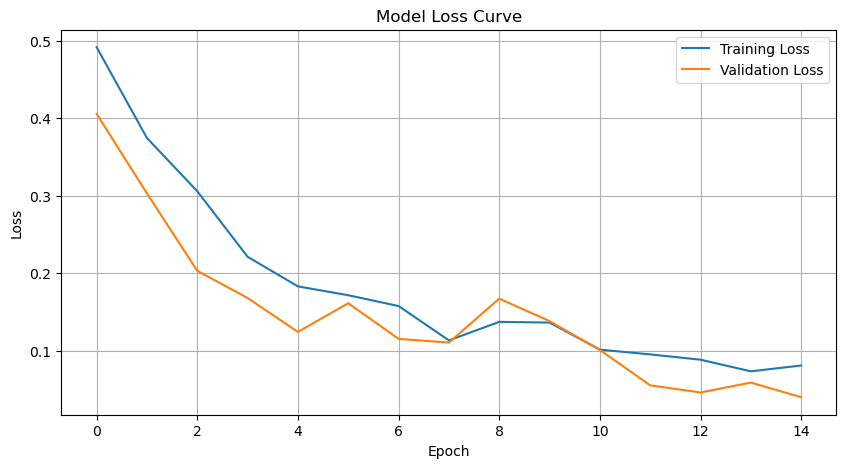

In [13]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()  # 显示图像